(All images used have either been licensed from [shutterstock](https://www.shutterstock.com/image-illustration/novel-coronavirus-2019ncov-virus-covid-19ncp-1725229615) or created by me)

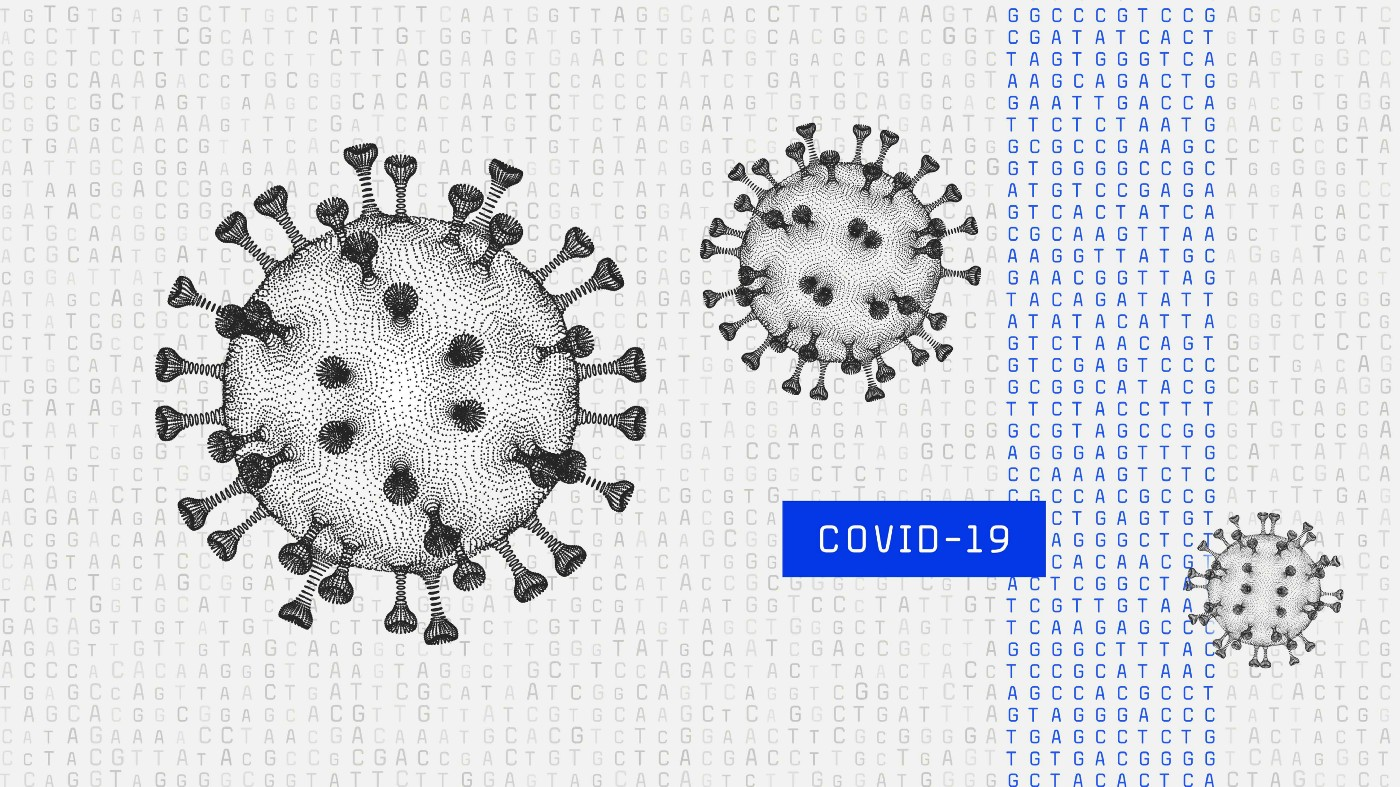

# 1. Introduction

The Covid 19 pandemic had wreaked havoc on our planet two years ago. In an attempt to better understand pandemics, I have created a simulation for modeling the virus spread.

In this simulation, we will take a look at how diseases spread across populations and how measures like wearing masks, lockdowns and vaccines affect this spread of diseases.

# 2. Approach

Machine Learning is excellent for building predictive models where we have access to lots of reliable data. However, if reliable data is not available, ML models perform poorly. Therefore, I decided to take an agent-based simulation modeling approach using object-oriented programming (OOP) concepts in Python.

# 3. Simulation Building Blocks

In my simulation, people/agents travel to different locations randomly each day. Up to 5 people can gather at each location.
At the start of each simulation, I have assumed a certain small number of people to be already infected by Covid.

Now, when an uninfected (healthy) person meets an infected person, there is a certain probability of catching Covid. This probability depends on various factors; whether people are wearing masks, number of people gathered at a location, and whether the people are vaccinated or not.

Let’s take a scenario where a healthy person meets an infected person. There can be three different cases; 1) both of them are wearing masks, 2) one of them is wearing a mask, or 3) neither of them is wearing a mask. As per studies, the probability of contracting Covid can be as high as 90% if nobody is wearing a mask. However, if one of them is wearing a good mask, chance of infection drops to 10%. So, if both are wearing masks, the probability of catching Covid becomes 1% (0.1*0.1).

Calculating this probability for multiple people can become complicated very fast. For example, at a given location, say an uninfected person meets 4 people, where some of them may be infected, some may or may not be wearing masks, and the person themselves may or may not be wearing a mask.

To understand how these probablities are calculated in the simulation, let’s take a situation where an uninfected person A (wearing a mask) meets infected people B (wearing a mask) and C (not wearing a mask).

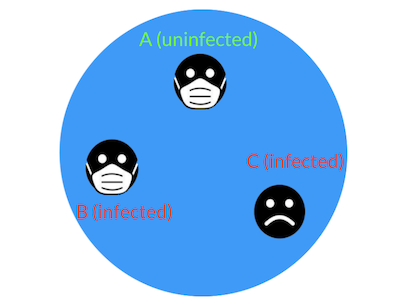

`P(A infected by B)` is 0.01 and `P(A infected by C)` is 0.1.

So the total probability of A getting infected at all (i.e. A getting infected by either of B and C or both B and C), let’s call it `P(A_infected)`, is `1 — P(A not infected by both of them)`,

where `P(A not infected by both of them)` is `P(A not infected by B) * P(A not infected by C)` which is the same as: `1 — P(A infected by B) * 1 — P(A infected by C)`.

Therefore, `P(A_infected) = 1 — [{1 — 0.01} x {1 — 0.1} = 1 — [(1 — 0.01) x (1 — 0.1)] = 0.109`. So, the probability of A getting infected in this situation is 0.109, or 10.9%.

# 4. The Simulation

**Initial Conditions**

In [1]:
total_population = 500 # Total Starting Population of people 

percent_masked = 50 # Percentage of people wearing masks

lockdown_intensity_ = 0 # must range from 0 to 3, 0 being least intense and 3 being most intense lockdown
change_lockdown_on = False # enable dynamic lockdowns: lockdown intensity automatically varies with the percentage of population infected
# lockdown_intensity_ will become 0 initially if change_lockdown_on = True
vaccinate_percent = 0.0 # percent of people to be vaccinated everyday 

num_of_generations = 80 # Number of days to run the simulation

Libraries

In [ ]:
!pip install bubbly
!pip install icecream
import csv
import math
import random
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import matplotlib.patches as mpatches
from icecream import ic
from matplotlib import rc
from random import shuffle
from IPython.display import HTML
from bubbly.bubbly import bubbleplot 
from plotly.offline import init_notebook_mode, iplot

In [3]:
incubation_period = 14 # How many days does the virus live
fatality = 2 # What percent of population dies on acquiring the disease
population_density = 30 # Percent of capacity of places filled by people

if change_lockdown_on:
  lockdown_intensity_ = 0

lockdown_intensity = 3.0 - lockdown_intensity_

change_vaccination_rate_on = False

d = { # Contains values for probabilities of catching the virus based on how many people are wearing masks
    'mm': 0.01, # Both wearing masks
    'mn': 0.1, # One wearing mask
    'nm': 0.1, # One wearing mask
    'nn': 0.9 # Nobody wearing a mask
}
# with_mask_prob_infect = 0.10 # probability of getting infected with people wearing masks
# without_mask_prob_infect = 0.90 # probability of getting infected without anyone wearing a mask

Running the Simulation

In [4]:
persons = [] # list of human (person) objects
masks = [] # list of masked objects
maskless = [] # list of unmasked objects
places = [] # list of place objects
persons2 = [] # list of quarantined people

count_quarantined = [] # Counts current number of quarantined people
num_mask = round((percent_masked*total_population)/100) # Starting number of mask objects
num_maskless = total_population - num_mask # Starting number of maskless objects
num_place = round(total_population/(population_density*0.05)) # Number of different places people can be at GIVEN MAX PEOPLE IN ONE PLACE IS 5

vaccinate_frequency = round((vaccinate_percent*total_population))/100 # number of people to vaccinated everyday
# mask_prob_infect = with_mask_prob_infect

total_mask_infected = 0
total_maskless_infected = 0
cumulative_infected = 0
total_vaccinated_people = 0

In [5]:
# Functions used later
def less_than_num_prob(probability):
  """returns True, with the probability of returning True equal to the parameter, returns False otherwise"""
  return random.randint(1, 100) <= probability

def pinv(num):
  """returns 1 - num as long as parameter is between 0 and 1"""
  if num >= 0.0 and num <= 1.0:
    return 1 - num

In [6]:
## CREATING LOCATION CLASS
class Place:
  def __init__(self, value, person1, person2, person3, person4, person5):
    self.value = value # How many additional people this place can occupy
    self.person1 = person1 # Type of person on place object
    self.person2 = person2 # Type of person on place object
    self.person3 = person3 # Type of person on place object
    self.person4 = person4 # Type of person on place object
    self.person5 = person5 # Type of person on place object

  def get_value():
    print(self.value)

In [7]:
## CREATE LOCATION OBJECTS
for i in range(num_place):
  places.append(Place(5.0, None, None, None, None, None))

In [8]:
def all_place_occupied():
  """Checks if all place objects have been completely occupied by persons"""
  temp = True
  for place in places:
    if None in [place.person1, place.person2, place.person3, place.person4, place.person5]:
      temp = False
  return temp


def all_people_vaccinated():
  """Checks if all people have been vaccinated"""
  temp = True
  for person in persons:
    if not person.is_vaccinated:
      temp = False
  return temp

In [9]:
## CREATE PERSON CLASSES
class Person:
  def __init__(self, place_num, place_received, is_infected, is_vaccinated):
    self.place_num = place_num
    self.place_received = place_received
    self.is_infected = is_infected
    self.is_vaccinated = is_vaccinated

  def assign_place(self):
    """Assigns available place object to the person. Person remains unassigned if all place objects are occupied"""
    person_assigned = False
    while person_assigned == False and not all_place_occupied():
      x = random.randint(0, len(places) - 1)
      if not places[x].value == 0:
        self.place_num = x
        person_assigned = True
        setattr(places[x], 'person' + str(int(6 - (places[x].value))), self)
        places[x].value -= 1.0

  def person_die(self):
    """Has a probability of 2% of killing infected people"""
    if self.is_infected and less_than_num_prob(fatality):
      persons.remove(self)

class Mask(Person):
  pass

class Maskless(Person):
  pass

In [10]:
## CREATE People OBJECTS
for i in range(num_mask):
  persons.append(Mask(0, -1.0, False, False))
for i in range(num_maskless):
  persons.append(Maskless(0, -1.0, False, False))

shuffle(persons)
for person in persons: #Assigns a place to each person
  person.assign_place()


THE FIRST COVID POSITIVE PEOPLE

In [11]:
for i in range(10):
  persons[i].is_infected = True
  persons[i].days_left = 14

  if isinstance(persons[i], Mask):
    total_mask_infected += 1
  else:
    total_maskless_infected += 1

In [12]:
def get_prob(list1):
  result = 1
  for l in list1:
    result *= pinv(d[l])
  return round(pinv(result), 3)

In [13]:
def sick_countdown():
  """Manages recovery from disease after a particular number of days"""
  for person in persons:
    if person.is_infected:
      person.days_left -= 1
      if person.days_left == 0:
        person.is_infected = False
        person.is_vaccinated = True

def transmit_disease():
  """Distributes disease viruses at each generation"""

  global total_mask_infected
  global total_maskless_infected

  for place in places:
    temp = True
    place_persons = [place.person1, place.person2, place.person3, place.person4, place.person5]
    if lockdown_intensity != 0:
      del(place_persons[:int(lockdown_intensity)])
    for i in place_persons:
      if i is None:
        temp = False
    infected = []
    non_infected = []
    mask_rates = 1
    if temp:
      for i in place_persons:
        if i.is_infected:
          infected.append(i)
        else:
          non_infected.append(i)

  ###################
    # Calculating probabilities of people getting infected
    for i in non_infected:
      values = []
      if isinstance(i, Mask):
        value1 = 'm'
      else:
        value1 = 'n'
      for j in infected:
        if isinstance(j, Mask):
          value2 = 'm'
        else:
          value2 = 'n'
        values.append(value1+value2) # Creates list with 'mm', 'mn' values. Putting in get_prob function return probability

      if less_than_num_prob(get_prob(values) * 100) and not i.is_vaccinated:
        i.is_infected = True
        if isinstance(i, Mask):
          total_mask_infected += 1
        elif isinstance(i, Maskless):
          total_maskless_infected += 1
        i.days_left = incubation_period


def vaccinate_people():
  """Vaccinates 'vaccinate_frequency' number of people every day"""
  global total_vaccinated_people
  num = len(persons)
  i = 0
  j = 0
  while i < vaccinate_frequency and not all_people_vaccinated() and j < total_population:
    x = random.randint(0, num - 1)
    if persons[x].is_vaccinated or persons[x].is_infected:
      i -= 1
    else:
      persons[x].is_vaccinated = True
      total_vaccinated_people += 1
    i += 1
    j += 1

In [14]:
def reset_values():
  for place in places: # Resetting place object values for next iteration
    place.value = 5.0 - lockdown_intensity
    place.person1 = None
    place.person2 = None
    place.person3 = None
    place.person4 = None
    place.person5 = None
  for person in persons: # Resetting person object values for next iteration
    person.place_num = 0
    person.place_received = -1.0
    person.assign_place()

def count_masks():
  count = 0
  for person in persons:
    if isinstance(person, Mask):
      count += 1
  return count

def count_maskless():
  count = 0
  for person in persons:
    if isinstance(person, Maskless):
      count += 1
  return count

def count_infected_people():
  """Counts the number of infected people"""
  num_infected = 0
  for person in persons:
    if person.is_infected:
      num_infected += 1
  return num_infected


def count_infected_people_by_mask():
  mask_infect = 0
  for person in persons:
    if person.is_infected and isinstance(person, Mask):
      mask_infect += 1
  return mask_infect

def count_infected_people_by_maskless():
  maskless_infect = 0
  for person in persons:
    if person.is_infected and isinstance(person, Maskless):
      maskless_infect += 1
  return maskless_infect

def count_cumulative_infected():
  global cumulative_infected
  for person in persons:
    if person.is_infected and person.days_left == 14:
      cumulative_infected += 1

Iterating through the number of days

In [15]:
total_num_infected = []
vaccinations = []
mask_infected = []
maskless_infected = []
dead_masked_people = []
dead_maskless_people = []
cumulative_infected_list = []
pop_vs_generation = {} # Dictionary containing generation number and number of persons alive



ic.disable()
for i in range(num_of_generations): # Each iteration is one generation
  ic("generation", i+1)
  for place in places:
    ic(place.person1, place.person2, place.person3, place.person4, place.person5)

  transmit_disease()
  count_cumulative_infected()
  sick_countdown()
  

  cumulative_infected_list.append(cumulative_infected)
  vaccinate_people()
  vaccinations.append(total_vaccinated_people)

  for person in persons:
    person.person_die()

  dead_masked_people.append(num_mask - count_masks())
  dead_maskless_people.append(num_maskless - count_maskless())
  infected_people = count_infected_people()
  total_num_infected.append(infected_people)
  mask_infected.append(count_infected_people_by_mask())
  maskless_infected.append(count_infected_people_by_maskless())
  count_quarantined.append(len(persons2))


  pop_vs_generation[i+1] = infected_people


  reset_values()
  ic("Generation", i+1, "over")
  ic('\n\n')
  if change_lockdown_on:
    if infected_people/total_population >= 0.20:
      lockdown_intensity = 0.0
    elif infected_people/total_population < 0.2 and infected_people/total_population >= 0.1:
      lockdown_intensity = 2.0
    elif infected_people/total_population < 0.1:
      lockdown_intensity = 3.0
  if change_vaccination_rate_on:
    if i == 15:
      vaccinate_percent = 0.4
      vaccinate_frequency = round((vaccinate_percent*total_population))/100

# 5. Results

The graph below shows the results of the simulation when the above code is run

Note: Tweak the initial conditions at the top of the '4. The Simulation' section and see how the graph changes

A total of 349 people out of 500 were infected in this run
Total number of people vaccinated is 0
Lockdown intensity is 0 (on a scale of 0 to 3)
Tweak the initial conditions at the top of "4. The Simulation" and see how the graph changes


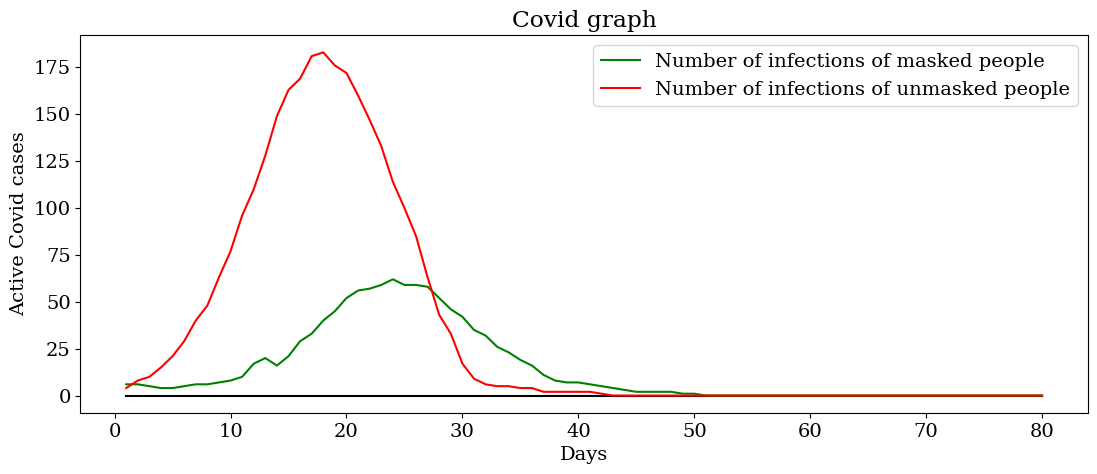

In [16]:
print("A total of", total_mask_infected+total_maskless_infected, 'people out of {} were infected in this run'.format(total_population))
print('Total number of people vaccinated is', total_vaccinated_people)
if change_lockdown_on:
  print('Lockdown intensity is varying with percentage of population infected')
else:
  print('Lockdown intensity is', lockdown_intensity_, '(on a scale of 0 to 3)')
print('Tweak the initial conditions at the top of "4. The Simulation" and see how the graph changes')
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'font.family': 'serif'})
w = 13
h = 5
d = 100
plt.figure(figsize=(w, h), dpi=d)
x1, y1, y2, y, x = [], [], [], [], []
for i in range(num_of_generations):
  x1.append(i+1)
  y1.append(0)
y2 = total_num_infected[:]
y3 = mask_infected[:]
y4 = maskless_infected[:]

plt.plot(x1, y1, color = 'black')
plt.plot(x1, y3, color = 'green', label = "Number of infections of masked people")
plt.plot(x1, y4, color = 'red', label = "Number of infections of unmasked people")

plt.legend();
plt.title("Covid graph");
plt.xlabel("Days");
plt.ylabel("Active Covid cases");

In [17]:
print("Total masked people who got infected is", total_mask_infected)
print("Total maskless people who got infected is", total_maskless_infected)

Total masked people who got infected is 102
Total maskless people who got infected is 247


===

Note: The graphs after this point have been generated from simulation data of multiple previous runs with the starting population as 10,000 people. 

Download the 'animation_data.csv' file from the Github repository to get data from those runs

===

##5.1 Efficacy of Masks

I executed three separate simulation runs, one where nobody wears masks, second where 50% of the people wear masks, and third where 75% of the people wear masks.

Here are the graphs from the three scenarios:

(Some Plotly graphs may rarely not form correctly the first time they are run. Rerunning the cell that plots the graph will fix the issue)

In [ ]:
data1 = pd.read_csv('animation_data.csv')
fdata1 = data1['Conditions'].isin(['No measures', '50% Masked', '75% Masked'])

fig1 = px.bar(data1[fdata1], x='Conditions', y='cumulative_infected_list', color='Conditions', 
                  hover_data=['Conditions'], animation_frame='Day', labels = {'Day': 'Number of days', 'cumulative_infected_list': 'Total number of people infected'}, 
                  title = 'Cumulative Cases vs Days', height = 600, range_y = [0, 10300])

fig2 = px.line(data1[fdata1], x='Day', y='cumulative_infected_list', color='Conditions', 
                  hover_data=['Conditions'], labels = {'Day': 'Number of days', 'cumulative_infected_list': 'Total number of people infected'}, 
                  title = 'Cumulative Cases vs Days')

fig3 = px.line(data1[fdata1], x='Day', y='total_infected', color='Conditions', 
                  hover_data=['Conditions'], labels = {'Day': 'Number of days', 'total_infected': 'Active infection cases'}, 
                  title = 'Active Cases vs Days')

figs = [fig1, fig2, fig3]

for fig in figs:
  fig.data[0].name = 'No Masks'
  fig.data[1].name = '75% Masked'
  fig.data[2].name = '50% Masked'
  fig.update_layout(
  font_family="Times New Roman",
  font_size=20,
)
fig1.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 200

In [ ]:
fig1.show()

(Click on the triangular 'play' button to start the animation)

In [ ]:
fig2.show()

In the scenario where nobody is wearing masks, everybody gets infected. As expected, the number of people who get infected is smaller when half of the people wear masks and even smaller when three quarters of the people do so.

For the same runs, here’s the graph for active cases vs days:

In [ ]:
fig3.show()

When nobody wears masks, at one point, almost 90% of the population was infected. The peaks of active cases are much more delayed and flattened when more people wear masks. This gives valuable time for hospital infrastructure to get ready for the pandemic.

Now, let’s look at a graph that shows the number of deaths in the scenario where 50% of the population is wearing masks.

In [ ]:
fdata2 = data1['Conditions'].isin(['50% Masked'])
new = data1[fdata2]
x=new['Day']

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=x, y=new['dead_masked_people'],
    hoverinfo='x+y',
    mode='lines',
    line=dict(width=0.5, color='rgb(5, 250, 5)'),
    name='Masked People Deaths',
    stackgroup='one' # define stack group
))
fig.add_trace(go.Scatter(
    x=x, y=new['dead_maskless_people'],
    hoverinfo='x+y',
    mode='lines',
    line=dict(width=0.5, color='rgb(220, 2, 1)'),
    name='Unmasked People Deaths',
    stackgroup='one'
))

fig.update_layout(yaxis_range=(0, max(new['dead_maskless_people']) + 600), xaxis_range=(0, 65),
                  title = 'Deaths vs Days', xaxis_title='Days', yaxis_title='Number of deaths', font_family="Times New Roman",
  font_size=20)
fig.show()

Even though an equal number of people wear and don’t wear masks, almost 3 times as many unmasked people die as masked people do. We can clearly see that wearing masks makes a huge difference in fighting Covid and significantly reduces both infections and deaths.

## 5.2 Efficacy of Lockdowns

Next, I added a lockdown effect to the simulation. Lockdowns are one way of fighting Covid where the number of people who can gather at one place is restricted. For our simulation, there are 4 intensities of lockdowns, ranging from 0 to 3 (lowest to highest). 

There is another level of lockdown called 'Dynamic Lockdown'. When it is activated (by setting change_lockdown_on = True), the lockdown intensity automatically varies based on what percentage of the population is infected at that time.

If we run the simulation with mild lockdown (intensity of 1), dynamic lockdown, and no lockdown, here is what we get:

In [ ]:
data1 = pd.read_csv('animation_data.csv')
fdata1 = data1['Conditions'].isin(['No measures', 'Only Mild Lockdown', 'Dynamic Lockdown'])

fig1 = px.bar(data1[fdata1], x='Conditions', y='cumulative_infected_list', color='Conditions', 
                  hover_data=['Conditions'], animation_frame='Day', labels = {'Day': 'Number of days', 'cumulative_infected_list': 'Total number of people infected'}, 
                  title = 'Cumulative Cases vs Days', range_y = [0, 10300])

fig3 = px.line(data1[fdata1], x='Day', y='total_infected', color='Conditions', 
                  hover_data=['Conditions'], labels = {'Day': 'Number of days', 'total_infected': 'Active infection cases'}, 
                  title = 'Active Cases vs Days')
fig2 = px.line(data1[fdata1], x='Day', y='cumulative_infected_list', color='Conditions', 
                  hover_data=['Conditions'], labels = {'Day': 'Number of days', 'cumulative_infected_list': 'Cumulative Cases'}, 
                  title = 'Cumulative Cases vs Days')
figs = [fig1, fig2, fig3]

for fig in figs:
  fig.data[0].name = 'No Lockdowns'
  fig.data[1].name = 'Dynamic Lockdowns'
  fig.data[2].name = 'Continuous Mild Lowckdown'
  fig.update_layout(
  font_family="Times New Roman",
  font_size=20,
)


fig1.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 200

In [ ]:
fig1.show()

In [ ]:
fig2.show()

As we see, cumulative cases rise the fastest when there is no lockdown. The mild and dynamic lockdown graphs cross each other a couple of times but end very close to each other. This may give an impression that mild lockdowns and dynamic lockdowns have similar effects on Covid cases. 

But let’s look at the active cases vs days graph for these 3 runs.

In [ ]:
fig3.show()

Even though the final number of total infection cases are almost the same for mild lockdowns and dynamic lockdowns, dynamic lockdowns are much better at flattening the curve. This means, when there are dynamic lockdowns, there will be fewer deaths as compared to mild lockdowns as hospital infrastructure (something we are not simulating) will not be overloaded. Also, economic activities won’t be disrupted as much.

## 5.3 Efficacy of Vaccinations‏‏‎ ‎

Vaccinations are yet another way of preventing Covid cases. For this simulation, we considered that upon being vaccinated, a person becomes immune to Covid-19. In other words, the probability of the person getting infected on exposure to infected people would become 0.

Running the simulation for no vaccinations, 0.4% vaccination rate (current average global vaccination rate), and 1% vaccination rate gives the following graph:

In [ ]:
data1 = pd.read_csv('animation_data.csv')
fdata1 = data1['Conditions'].isin(['No measures', '0.4% vax rate', '1% vax rate'])

fig1 = px.bar(data1[fdata1], x='Conditions', y='cumulative_infected_list', color='Conditions', 
                  hover_data=['Conditions'], animation_frame='Day', labels = {'Day': 'Number of days', 'cumulative_infected_list': 'Total number of people infected'}, 
                  title = 'Cumulative Cases vs Days', range_y = [0, 10300])

fig3 = px.line(data1[fdata1], x='Day', y='total_infected', color='Conditions', 
                  hover_data=['Conditions'], labels = {'Day': 'Number of days', 'total_infected': 'Active infection cases'}, 
                  title = 'Active Cases vs Days')
fig2 = px.line(data1[fdata1], x='Day', y='cumulative_infected_list', color='Conditions', 
                  hover_data=['Conditions'], labels = {'Day': 'Number of days', 'cumulative_infected_list': 'Total number infected'}, 
                  title = 'Active Cases vs Days')
figs = [fig1, fig2, fig3]

for fig in figs:
  fig.data[0].name = 'No Vaccinations'
  fig.data[2].name = '0.4% Vaccinations'
  fig.data[1].name = '1% Vaccinations'
  fig.update_layout(
  font_family="Times New Roman",
  font_size=20,
)


fig1.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 200

In [ ]:
fig1.show()

In [ ]:
fig2.show()

Cases rise fastest when there are no vaccinations, then at a 0.4% vaccination rate, and then a 1% vaccination rate.
Looking at the number of deaths for these 3 vaccination rates-

In [ ]:
fig4 = px.line(data1[fdata1], x='Day', y='total_dead', color='Conditions', 
                  hover_data=['Conditions'], labels = {'Day': 'Number of days', 'total_dead': 'Number of people dead'}, 
                  title = 'Deaths vs Days')
fig4.update_layout(
  font_family="Times New Roman",
  font_size=20,
)
fig4.show()

We see vaccinating 1% of the population daily caused almost 35% less deaths than when nobody was getting vaccinated.

## 5.4 Wrapping it up‎‎‎‎‎‏‏‎ ‎


To wrap it all up, let’s look at a graph that compares all the measures we have looked at so far, changing percentages of masked people, varying lockdown levels, and varying vaccination rates, to see which strategy works best against Covid.

These are the conditions I ran the simulation for:

*   No Masks, no lockdowns, no vaccinations
*   50% population wearing masks
*   75% population wearing masks
*   Mild lockdowns
*   Dynamic lockdowns
*   0.4% daily vaccination rate
*   1% daily vaccination rate

with the starting population being 10,000 people.

In [ ]:
figure = bubbleplot(dataset = pd.read_csv('animation_data.csv'), x_column='total_dead', y_column='cumulative_infected_list', 
    bubble_column='Day', size_column='total_dead', time_column = 'Day', color_column='Conditions', 
    x_title="Deaths", y_title="Number of infections", title='Covid simulation',
    x_logscale=False, scale_bubble=2, height=650);

figure['layout']['sliders'][0]['currentvalue']['prefix'] = 'Day:'

In [ ]:
iplot(figure);

(pull the circular slider to starting position to play the animation from start)

Clearly, all measures help in curbing the spread of Covid 19. However, the most effective measure in the battle against Covid according to this simulation is masks. And the good thing about masks is, the most effective weapon for preventing Covid is in our own hands.

# 6. Something extra (Sentiment Analysis)

We saw that masks are pretty important. Therefore, I wanted to see what the public perception of masks is. To do this, I employed Natural Language Processing, a part of Machine Learning that deals with understanding human language.

I went ahead and used sns scrape to download 10,000 recent Tweets from Twitter regarding wearing masks. Next, I used a python library called NLTK that uses a lexicon-based technique to implement sentiment analysis on the tweets.

`snscrape --jsonl --progress --max-results 10000 twitter-search "masks since:2021-07-01 until:2021-10-01" > text-query-tweets.json` was used in terminal to get the 10000 tweets.

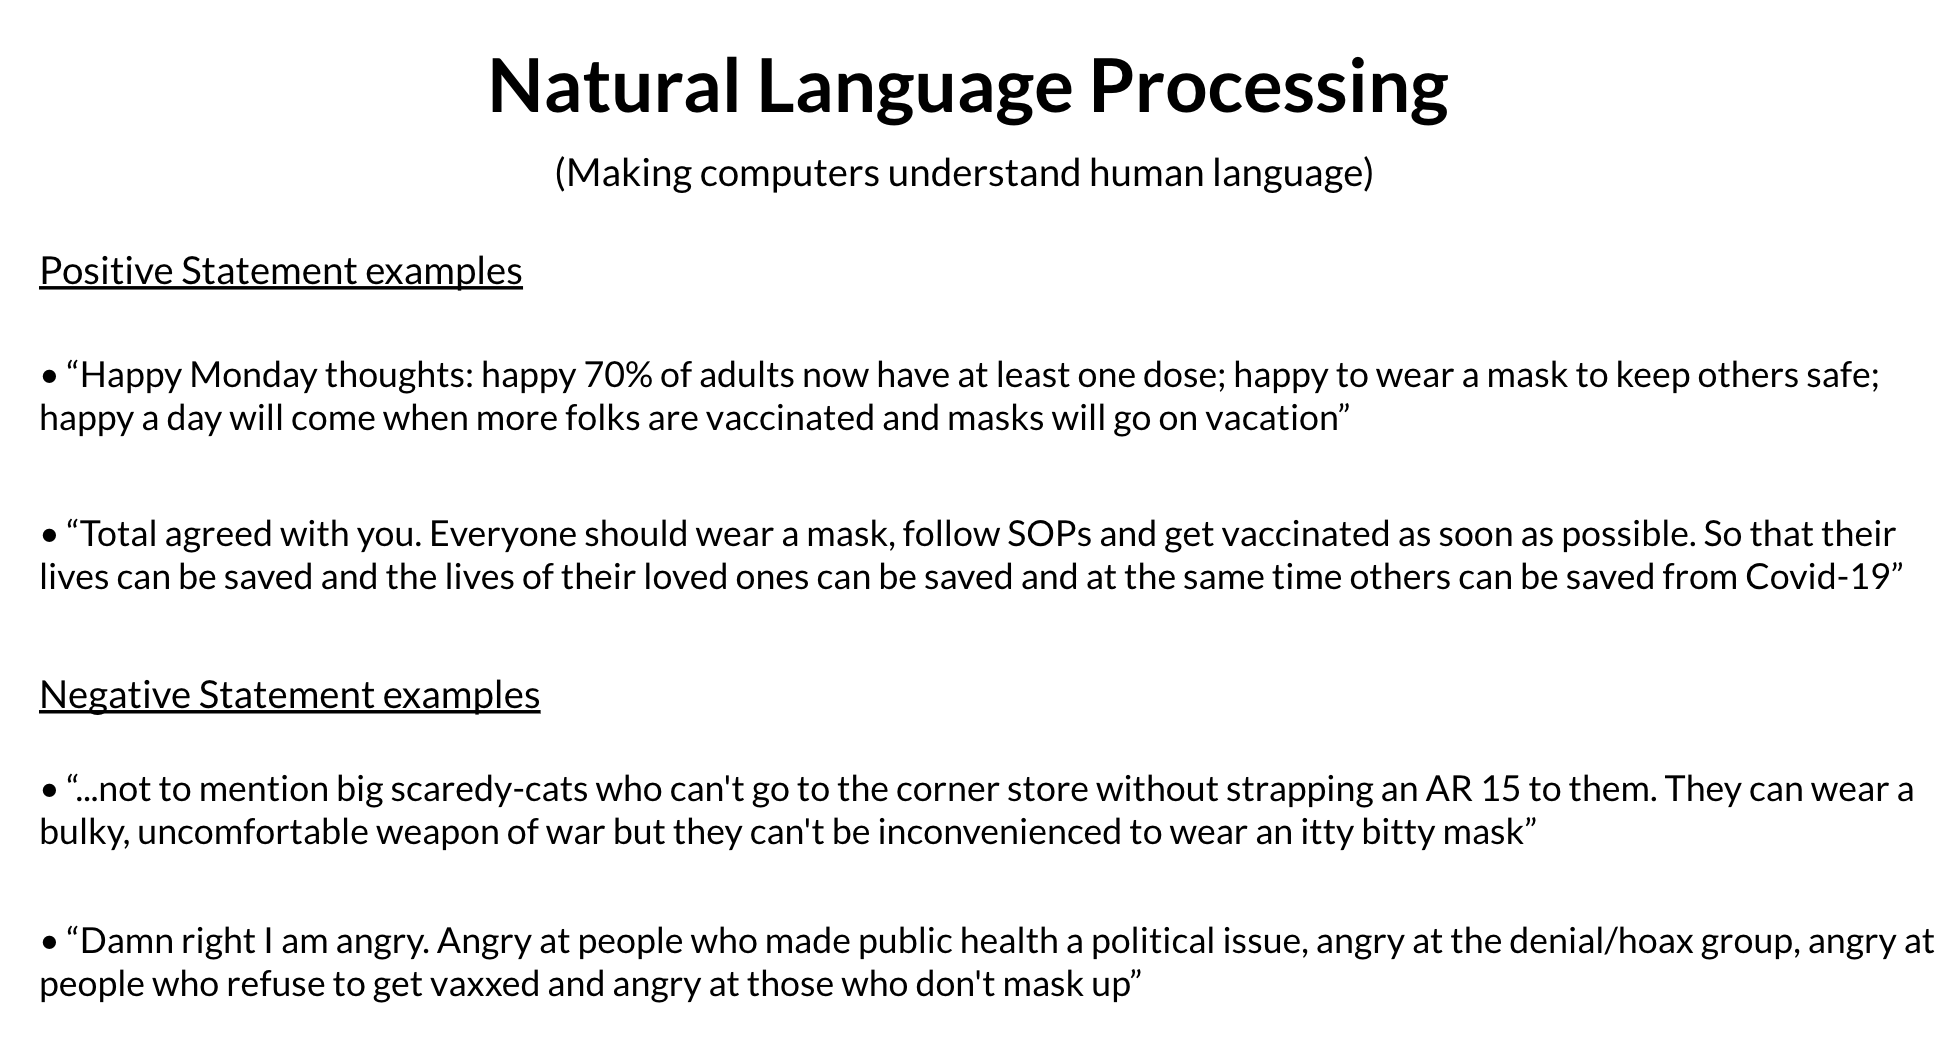

In [ ]:
# Code for performing sentiment analysis on tweets. This code is not run in this notebook.
# I ran this code separately while creating the data as the file containing all the 10000 tweets is too large.
sentiment_script = """def get_range(num):
    '''Gives the range of a given sentiment score'''
    if num < -0.1:
        return 'Negative'
    elif num >= -0.1 and num < 0.1:
        return 'Neutral'
    elif num >= 0.1:
        return 'Positive'

content = [] # Is the list of all tweets
with open('mask_tweets.json') as file:
    for line in file:
        list.append(str(line))

    for l in list:
        x = json.loads(l)
        content.append(x['content'])

with open('tweet_ranges.csv', 'w') as f: #
    f.write('Sentiments')
    f.write('\n')
    for c in content:
        score = sid.polarity_scores(c)['compound']
        f.write(get_range(score))
        f.write('\n')"""

When I made a pie chart comparing the number of positive tweets with the number of negative and neutral tweets, I saw that their numbers were almost equal. 33.7% of tweets were positive, 31.5% negative, and 34.7% neutral:

Note: The data used to create the graph below is taken from the 'tweet_ranges.csv' file. Download that file from the repository to run the cell below.

In [ ]:
# Data used for this graph was generated separately.
df = pd.read_csv('tweet_ranges.csv')
fig = px.pie(df, names = 'Sentiments', title = 'Sentiment scores for tweets about masks', hole=0.3)
fig.update_layout(
  font_family="Times New Roman",
  font_size=23,
)
fig.show()

This shows that despite masks being so crucial to prevent infection, a lot of people are still not taking wearing them seriously enough.

#7. Conclusion

Though this simulation is much less complicated than the actual world, it does a fair job of demonstrating how infection spreads across populations and the different ways people can prevent this spread. Some ways this can be made more realistic is adding testing people for Covid and quarantining them, adding occasional large gatherings representing religious or political rallies, having different vaccination and lockdown policies in different parts of a population, etc.


Thanks for reading!
